In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostRegressor

input_file = "path to power_data.csv"
pd.set_option('display.max_columns', None)
df = pd.read_csv(input_file, on_bad_lines='skip')
df = df.iloc[: , 1:]

Take a look on the data

In [2]:
print(df)  # check the data

                  Datetime  Power_MWH
0      2010-01-01 00:00:00    31647.0
1      2010-12-31 01:00:00    29634.0
2      2010-12-31 02:00:00    28614.0
3      2010-12-31 03:00:00    28146.0
4      2010-12-31 04:00:00    28051.0
...                    ...        ...
75250  2018-01-01 20:00:00    44284.0
75251  2018-01-01 21:00:00    43751.0
75252  2018-01-01 22:00:00    42402.0
75253  2018-01-01 23:00:00    40164.0
75254  2018-01-02 00:00:00    38608.0

[75255 rows x 2 columns]


The data only provide one column of feature and one column of ground truth, the challenging part is to perform the appropriate feature engineering on the 'Datetime'column to generate other features that is related to time. It could possibly be using regression models for the solution.

In [3]:
print(df.dtypes) # check the data types

Datetime      object
Power_MWH    float64
dtype: object


Check if there are any nan values in this dataframe. We will drop the rows that contain nan value as there are only one features/ground truth in each row.

In [4]:
print(df.isnull().sum())
print('total rows with nan values:', df.isnull().sum().sum())

Datetime     0
Power_MWH    0
dtype: int64
total rows with nan values: 0


There are no nan values in the dataframe. 
Let's see if there are any missing dates, we start from getting the date range of original dataset.

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])  # for sorting
df.sort_values(by=['Datetime'], inplace=True)
df = df.reset_index(drop=True)
print(df.head())
print(df.tail())

             Datetime  Power_MWH
0 2010-01-01 00:00:00    31647.0
1 2010-01-01 01:00:00    30075.0
2 2010-01-01 02:00:00    28907.0
3 2010-01-01 03:00:00    27906.0
4 2010-01-01 04:00:00    27373.0
                 Datetime  Power_MWH
75250 2018-08-02 20:00:00    44057.0
75251 2018-08-02 21:00:00    43256.0
75252 2018-08-02 22:00:00    41552.0
75253 2018-08-02 23:00:00    38500.0
75254 2018-08-03 00:00:00    35486.0


Let's take a look on the missing data

In [6]:
missing_date = pd.date_range(start='2010-01-01 00:00:00', end='2018-08-03 00:00:00', freq='h').difference(df['Datetime'])
print(missing_date)

DatetimeIndex(['2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)


There are only few data are missing, we believe that it could be ignored comparing to 75255 data rows, and not going to fill the missing date with median/mean.  
The missing dates are similar in every year, it may due to the annual maintenance of the power system.    

# Data visualization

For better visualization and model training, the 'Datetime' column can be divided into year, month, day, hour for further analysis

In [7]:
df['hour'] = df['Datetime'].dt.hour
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['MM-DD-HH'] = df['Datetime'].dt.strftime('%m-%d-%H')  # for visualization
print(df.head())

             Datetime  Power_MWH  hour  year  month  day  MM-DD-HH
0 2010-01-01 00:00:00    31647.0     0  2010      1    1  01-01-00
1 2010-01-01 01:00:00    30075.0     1  2010      1    1  01-01-01
2 2010-01-01 02:00:00    28907.0     2  2010      1    1  01-01-02
3 2010-01-01 03:00:00    27906.0     3  2010      1    1  01-01-03
4 2010-01-01 04:00:00    27373.0     4  2010      1    1  01-01-04


### Let's plot the power consumption against every hour for the year from 2010 to 2018

<Axes: title={'center': '2010-2018'}, xlabel='MM-DD-HH'>

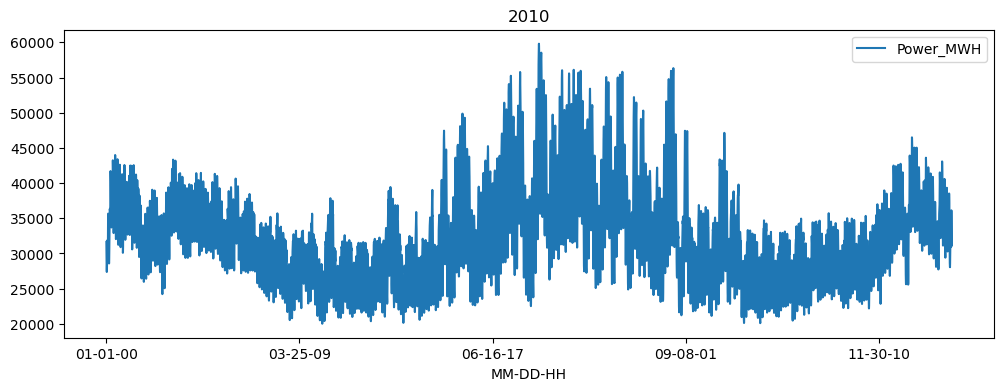

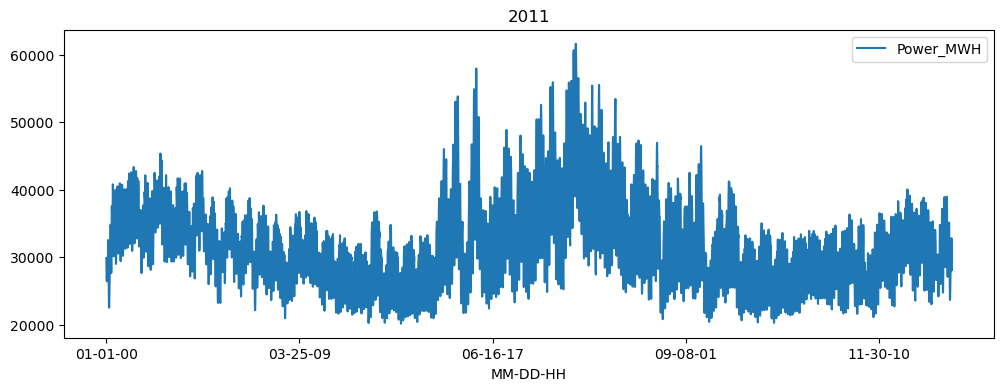

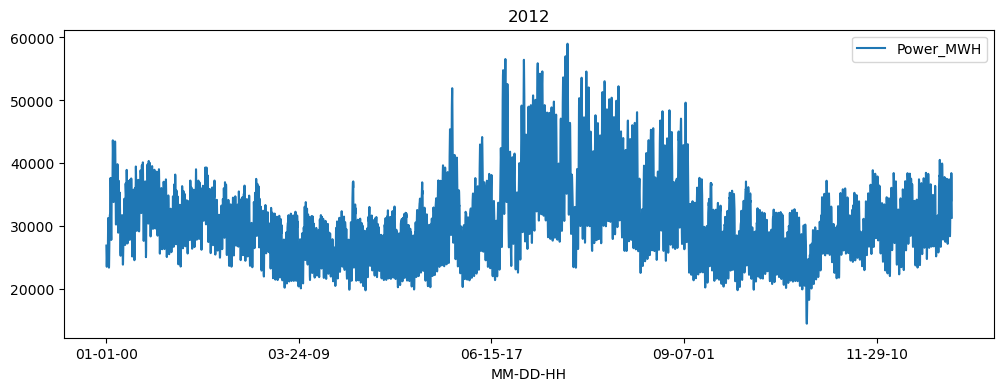

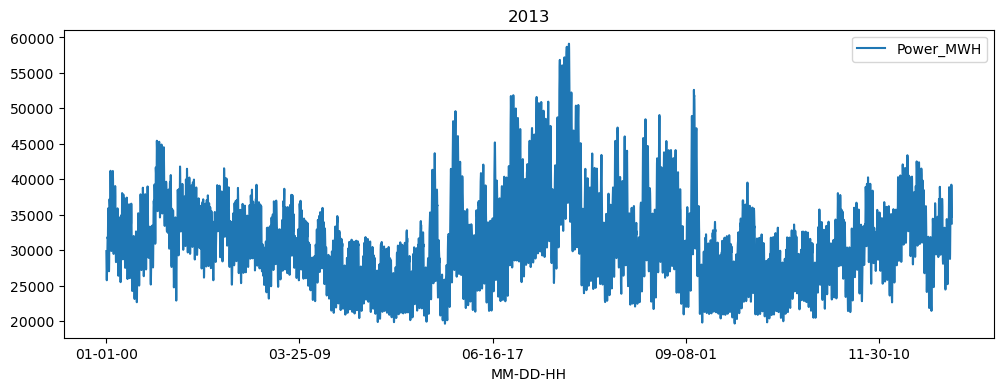

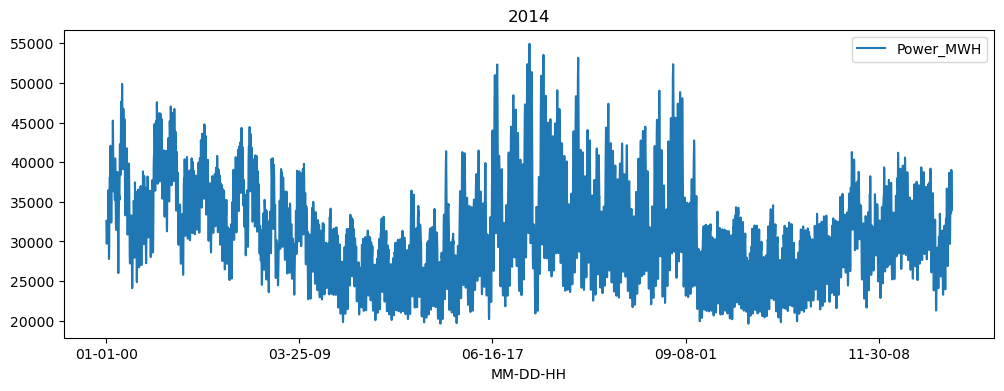

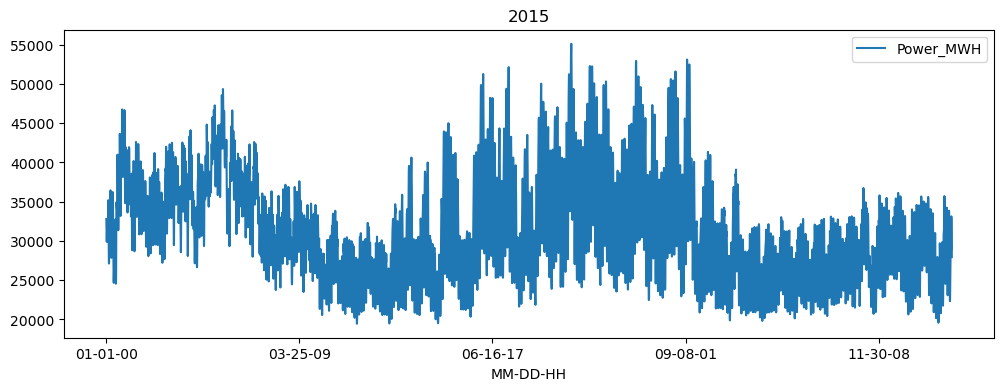

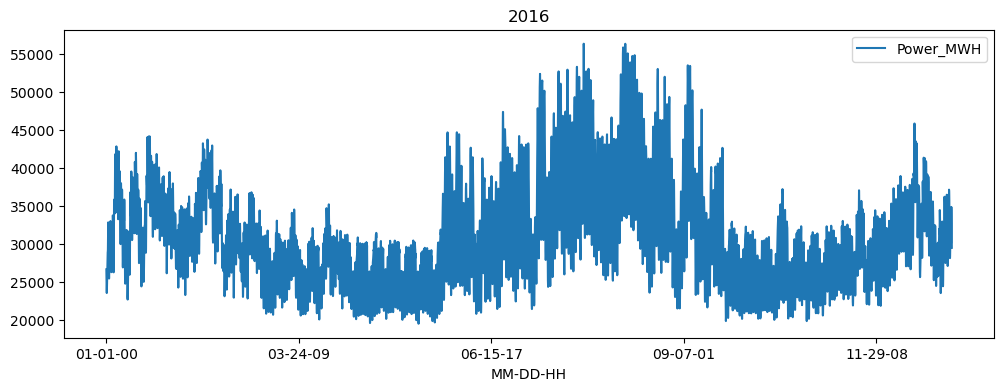

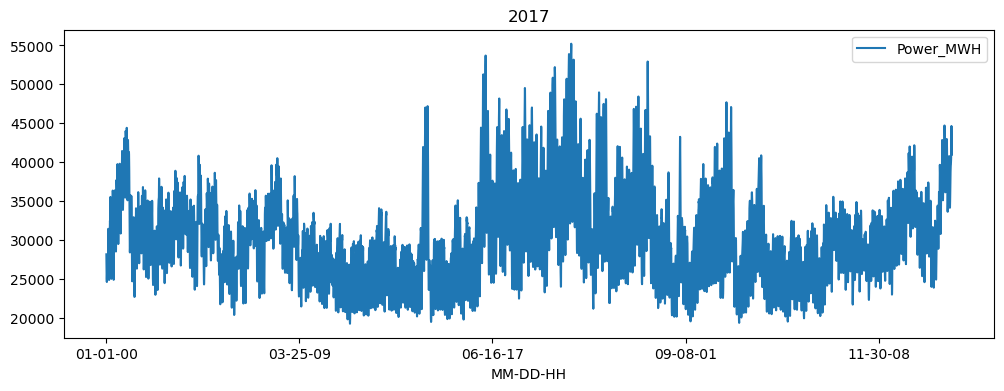

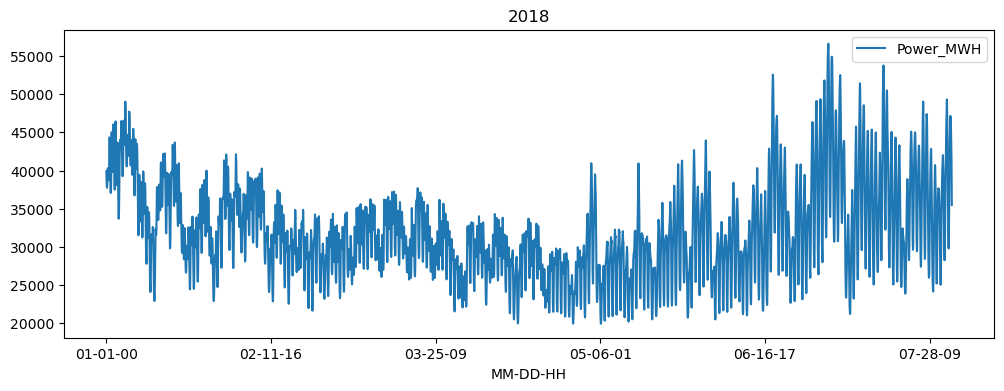

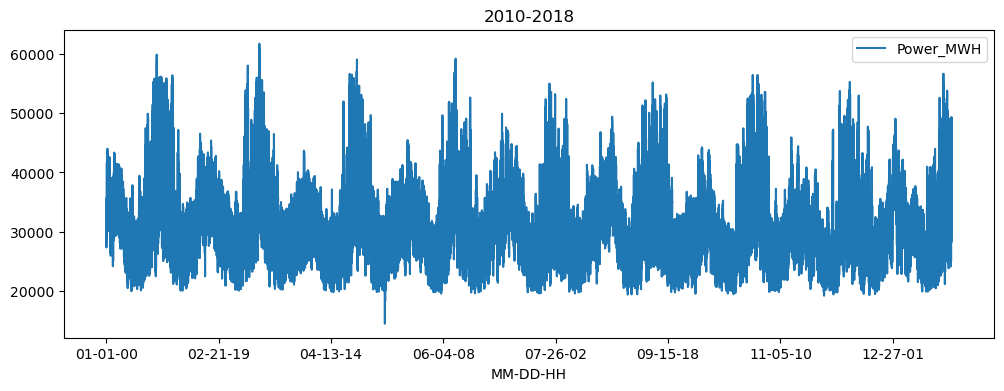

In [8]:
yearlist = [2010,2011,2012,2013,2014,2015,2016,2017,2018]
for i in yearlist:
    vis = df[df['year']==i]
    vis.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), title=i)    
df.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), title='2010-2018')

## There are patterns in the power consumption, let's look into the data of first week

<Axes: title={'center': '1 week'}, xlabel='MM-DD-HH'>

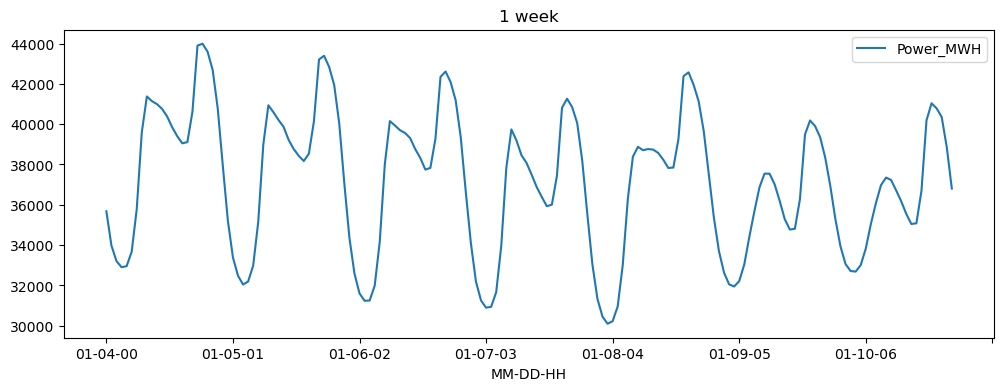

In [9]:
vis = df[(df['Datetime'] >= '2010-01-04 00:00:00') & (df['Datetime'] < '2010-01-11 00:00:00')]
vis.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), title='1 week') 

## Now we stack two months of data to see if the pattern still continue

<Axes: title={'center': '2 months stack'}, xlabel='MM-DD-HH'>

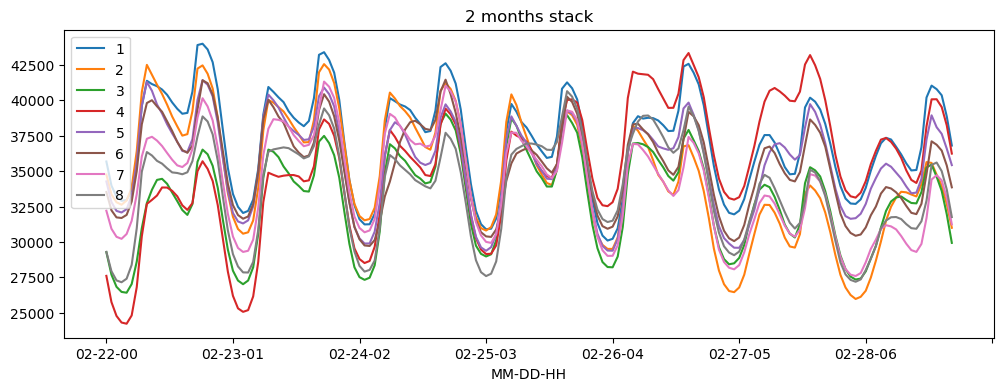

In [10]:
vis = df[(df['Datetime'] >= '2010-01-04 00:00:00') & (df['Datetime'] < '2010-01-11 00:00:00')]
vis2 = df[(df['Datetime'] >= '2010-01-11 00:00:00') & (df['Datetime'] < '2010-01-18 00:00:00')]
vis3 = df[(df['Datetime'] >= '2010-01-18 00:00:00') & (df['Datetime'] < '2010-01-25 00:00:00')]
vis4 = df[(df['Datetime'] >= '2010-01-25 00:00:00') & (df['Datetime'] < '2010-02-01 00:00:00')]
vis5 = df[(df['Datetime'] >= '2010-02-01 00:00:00') & (df['Datetime'] < '2010-02-08 00:00:00')]
vis6 = df[(df['Datetime'] >= '2010-02-08 00:00:00') & (df['Datetime'] < '2010-02-15 00:00:00')]
vis7 = df[(df['Datetime'] >= '2010-02-15 00:00:00') & (df['Datetime'] < '2010-02-22 00:00:00')]
vis8 = df[(df['Datetime'] >= '2010-02-22 00:00:00') & (df['Datetime'] < '2010-03-01 00:00:00')]

vis = vis.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), label='1')
vis2 = vis2.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis, label='2')
vis3 = vis3.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis2, label='3')
vis4 = vis4.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis3, label='4')
vis5 = vis5.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis4, label='5')
vis6 = vis6.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis5, label='6')
vis7 = vis7.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), ax=vis6, label='7')
vis8.plot(x='MM-DD-HH', y='Power_MWH', kind='line', figsize=(12, 4), title='2 months stack', ax=vis7, label='8')

## Now we can assume that the pattern occur every day, let's look into data of first day

<Axes: title={'center': '1 day'}, xlabel='hour'>

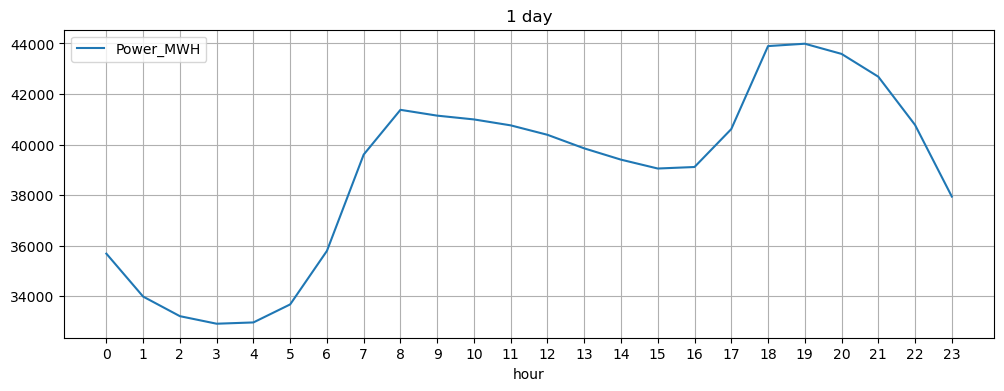

In [11]:
vis = df[(df['Datetime'] >= '2010-01-04 00:00:00') & (df['Datetime'] <= '2010-01-04 23:00:00')]
vis.plot(x='hour', y='Power_MWH', kind='line', figsize=(12, 4), title='1 day', xticks=vis['hour'], grid=True) 

## First assumption: the pattern will occur everyday, the hour is related to power consumption
Now we can calculate the average power consumption of each hour, and may use the rank of average value as a feature

<Axes: title={'center': 'Average power consumption per hour'}, xlabel='hour'>

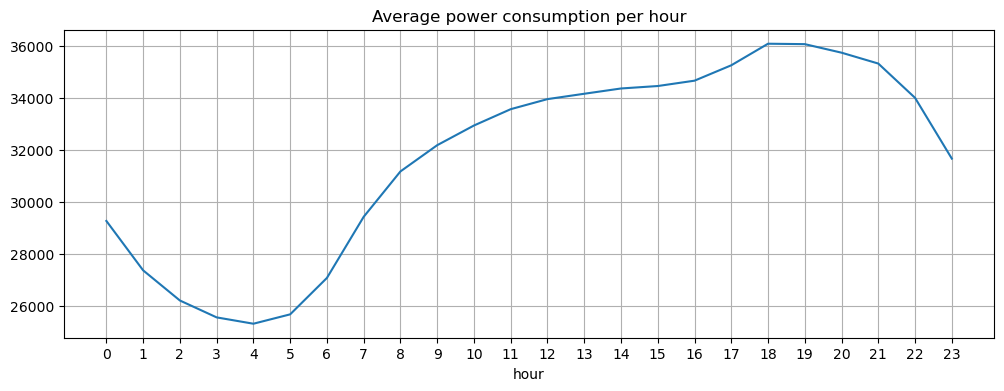

In [12]:
df_hour_rank = df.groupby(df['hour'])['Power_MWH'].mean()
df_hour_rank.plot(x='hour', y='Power_MWH', kind='line', figsize=(12, 4), title='Average power consumption per hour', xticks=vis['hour'], grid=True)

After visualization of power consumption for each year, we found that the shapes of curve are similar, it maybe a time-series related problem.  
Also, we found that the data of 2018 is not completed, we may use data from 2010-2017 to fit our model first.  
The power consumption is possibly related to the temperature, as the power consumption goes up during the summer and lower in the rest of months. It will be evaluated in later stage. Some possible models can be used to predict the future trends for power consumption:  
## 1. Polynomial regression model
It combines the polynomial transform and regression model to fit the data and give a generalized shape of curve for prediction.
### Pros: 
1. Low computational cost is required, fast visualization for first insight
2. Could give a reasonable solution for time-series data as it can capture the pattern of preivous data
### Cons:  
1. Difficult to fine tune the model
2. Only give approximated solution, cannot give accurate prediction

## 2. FBProphet model
### Pros:
1. Easy to use, simple input with ds and y only
2. Low computational power is required
### Cons:
1. Only sensitive to time-related features, non-time related feature engineering become less effective 
2. Not much fine tuning can be done

## 3. XGBoost / CatBoost regression model
### Pros: 
1. Low computational cost is required
2. Fine tuning is provided
3. Could combine the weak features into stronger features, which can be used to evaluate the feature importance
4. CatBoost can handle categorical data
### Cons:
1. Sensitive to outliers
2. Easy to overfitting
## 4. MLP network with moving average
### Pros: 
1. Could handle the correlation between the features
2. Could scale up the network for larger dataset
3. Fine tuning is provided
### Cons:
1. High computational power is required
2. Need more feature engineering in moving average values
3. Could perform poor with small number of features
## 5. Transformer model
### Pros: 
1. Built for series data
2. Provide long term memory comparing to RNN and LSTM
3. Fine tuning is provided
### Cons:
1. High computational power is required
2. Requires a huge amount of data to train
3. Easy to overfitting

# Feature Engineering

There is a trend of day hours from the previous plot, thus we divided the mean power consumption into three groups and assign into each hour

In [13]:
rank_index = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2]
hour_to_rank = dict(zip(range(0,24), rank_index))
df['hour_rank_gp'] = df['hour'].map(hour_to_rank) 
# df_hour_rank = df_hour_rank.sort_values()
# df_hour_rank = df_hour_rank.reset_index()
# df_hour_rank = df_hour_rank.sort_values(by='hour')
# rank_index = df_hour_rank.index.values
# hour_to_rank = dict(zip(range(0,24), rank_index))
# df['hour_rank'] = df['hour'].map(hour_to_rank) 

There is also another trend that shows the power consumption goes from high to low in the range from Monday to Sunday. So we also add the data of the week as our new feature.

In [14]:
df['day_of_the_week'] = df['Datetime'].dt.dayofweek

The power may related to business hour of the offices, it is our second assumption and it will be evaluated in later part.  
So we add 'is_weekend' and 'business_hour' as new features

In [15]:
df['is_weekend'] = df['Datetime'].dt.dayofweek > 4

m = (9 <= df['hour']) & (df['hour'] < 18) & (df['is_weekend'] == 0)
df['business_hour'] = np.where(m, 1, 0)

The power consumption may related to temperature, it is our third assumption.  
In the perspective of correlation between month and temperature, the number of month does not reflect the temperature of each month. Season maybe a better representation of temperature, below cell will assign season index for each month

In [16]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
df['season'] = df['month'].map(month_to_season) 

check the correlation matrix between ground truth and each feature

In [17]:
corr_matrix = df.corr(numeric_only=True)['Power_MWH'].abs().sort_values(ascending=False)
print(corr_matrix)

Power_MWH          1.000000
hour_rank_gp       0.523136
hour               0.469499
business_hour      0.315767
is_weekend         0.206336
day_of_the_week    0.167077
season             0.081915
year               0.077155
month              0.069917
day                0.007627
Name: Power_MWH, dtype: float64


The correlation score of season is higher than month now, but it is not convincing enough. There may be too many groups in the season, it could be divided into 2 groups according to the observation of power consumption for each month. Summer would be class 2 while other seasons would be classified as class 1.

In [18]:
new_seasons = [1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]
month_to_season = dict(zip(range(1,13), new_seasons))
df['new_season'] = df['month'].map(month_to_season) 

Let’s see how the new feature 'new_season' is correlated to ground truth

In [19]:
corr_matrix = df.corr(numeric_only=True)['Power_MWH'].abs().sort_values(ascending=False)
print(corr_matrix)

Power_MWH          1.000000
hour_rank_gp       0.523136
hour               0.469499
new_season         0.363161
business_hour      0.315767
is_weekend         0.206336
day_of_the_week    0.167077
season             0.081915
year               0.077155
month              0.069917
day                0.007627
Name: Power_MWH, dtype: float64


The new season seems give a better correlation score comparing to the original season. It shows that there are strong correlation between the power consumption and the temperature/ Summer months.  
As there are two local minimum in the yearly curve, we may modify the number of groups from 2 to 3 by supervised annotations. The correlation score is expected to become higher as it is annotated by observation of change in power comsumption.

In [20]:
new_seasons = [2, 2, 1, 1, 1, 3, 3, 3, 1, 1, 1, 2]
month_to_season = dict(zip(range(1,13), new_seasons))
df['new_season'] = df['month'].map(month_to_season) 

corr_matrix = df.corr(numeric_only=True)['Power_MWH'].abs().sort_values(ascending=False)
print(corr_matrix)

Power_MWH          1.000000
hour_rank_gp       0.523136
hour               0.469499
new_season         0.451734
business_hour      0.315767
is_weekend         0.206336
day_of_the_week    0.167077
season             0.081915
year               0.077155
month              0.069917
day                0.007627
Name: Power_MWH, dtype: float64


Let's do the data cleaning and prepare for the training data

In [21]:
processed_df = df.iloc[: , 1:]  # drop the original 'Datetime' column
processed_df = processed_df.drop(['MM-DD-HH'], axis=1)  # drop the new 'MM-DD' column, previous used for visualization
print(processed_df.head())

   Power_MWH  hour  year  month  day  hour_rank_gp  day_of_the_week  \
0    31647.0     0  2010      1    1             1                4   
1    30075.0     1  2010      1    1             1                4   
2    28907.0     2  2010      1    1             1                4   
3    27906.0     3  2010      1    1             1                4   
4    27373.0     4  2010      1    1             1                4   

   is_weekend  business_hour  season  new_season  
0       False              0       1           2  
1       False              0       1           2  
2       False              0       1           2  
3       False              0       1           2  
4       False              0       1           2  


Label the non numerical data with preprocessing.LabelEncoder()

In [22]:
def df_label_encoder(df):

    le = preprocessing.LabelEncoder()
    columns = df.columns.values
    for column in columns:
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            df[column] = le.fit_transform(df[column].astype(str))

    return df

processed_df = df_label_encoder(processed_df)

In this section, we will try to split the dataset with cross validation by TimeSeriesSplit tool.  
We dropped the data of 2018 as it did not record whole year data, we may use the data of 2018 in further analysis.  

In [23]:
from sklearn.model_selection import TimeSeriesSplit

def sample_dataset(df, gt_col, test_ratio):

    X = df.drop([gt_col], axis=1).values
    y = df[gt_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio,random_state=0)

    return X_train, X_test, y_train, y_test

def time_series_split(df, gt_col, test_ratio):
    tss = TimeSeriesSplit(n_splits=2, test_size=int(len(df)*test_ratio))
    new_df = df.drop(df[df['year']==2018].index)  # drop 2018 data

    X = new_df.drop([gt_col], axis=1)
    y = new_df[gt_col]
    X_index1, X_index2 = tss.split(X)
    train_idx, test_idx = X_index2
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx,:]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test
    
# X_train, X_test, y_train, y_test = sample_dataset(df, gt_col='Power_MWH', test_ratio=0.1)
X_train, X_test, y_train, y_test = time_series_split(processed_df, gt_col='Power_MWH', test_ratio=0.1)

Let's check the time period of train and test dataset

In [24]:
print('train tail:')
print(X_train.tail())
print('test head:')
print(X_test.head())

train tail:
       hour  year  month  day  hour_rank_gp  day_of_the_week  is_weekend  \
62589     6  2017      2   21             1                1           0   
62590     7  2017      2   21             1                1           0   
62591     8  2017      2   21             2                1           0   
62592     9  2017      2   21             2                1           0   
62593    10  2017      2   21             2                1           0   

       business_hour  season  new_season  
62589              0       1           2  
62590              0       1           2  
62591              0       1           2  
62592              1       1           2  
62593              1       1           2  
test head:
       hour  year  month  day  hour_rank_gp  day_of_the_week  is_weekend  \
62594    11  2017      2   21             2                1           0   
62595    12  2017      2   21             2                1           0   
62596    13  2017      2   21     

# Case study
## Given previous year data and partial data of target year, predict the rest of target year data
In here, we use the data from 2010 to Feb 2017 as training data, Feb 2017 to Dec 2017 as testing data

## Building a baseline model  
In this section, we will build a baseline model with simple approach by fitting the data with a Polynomial regression model. 
As the shapes of curve between different years are similar, Polynomial regression model would give the reasonable solution with a generalized shape of curve. Also, its computation cost is low so that we can get the simple model in few seconds.


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

poly = PolynomialFeatures(degree=4, include_bias=True)
x_train_poly = poly.fit_transform(X_train)
x_test_poly = poly.transform(X_test)

lr = LinearRegression()
lr.fit(x_train_poly, y_train)

LinearRegression()

We use R-squared score to evaluate our regression models

r2 score of polynomial regression model: 0.47984681285028485


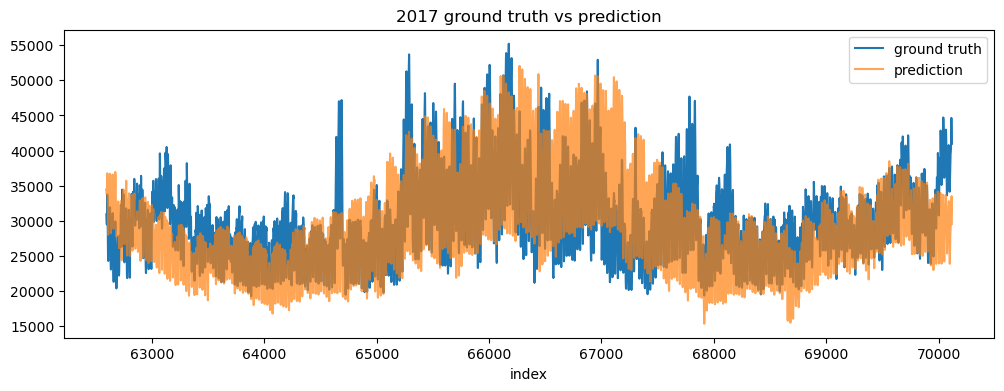

In [26]:
y_pred = lr.predict(x_test_poly)
print('r2 score of polynomial regression model:', r2_score(y_test, y_pred))

X_test = X_test.reset_index()
y_test = y_test.reset_index(drop=True)
y_pred = pd.DataFrame(y_pred, columns = ['Power_MWH'])

vis_gt = pd.concat([y_test, X_test], axis=1, join='outer')
vis_pred = pd.concat([y_pred, X_test], axis=1, join='outer')
vis1 = vis_gt.plot(x='index', y='Power_MWH', kind='line', figsize=(12, 4), label='ground truth')
vis2 = vis_pred.plot(x='index', y='Power_MWH', kind='line', figsize=(12, 4), title='2017 ground truth vs prediction', label='prediction', alpha=0.7, ax=vis1)


The baseline model gave an approximated curve for 2017 testing data, and results in r2 score of 0.4852  
Let's move forward to build a ML model for comparison 


## Build a ML model  
In the previous section, we proposed few ML models for the solution, including XGBoost / CatBoost, MLP network with moving average and Transformer model. All of them would give a reasonable results in time series forecasting problem. However, larger computational cost is needed to train the deep models comparing to the gradient boosting method. The size of dataset seems to be relatively small to train the transformer network, while MLP network requires longer training time and higher computational power. Thus, we will select the CatBoost model in this section as it gives a better balance of above criteria.

In [27]:
X_train, X_test, y_train, y_test = time_series_split(processed_df, gt_col='Power_MWH', test_ratio=0.1)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

model = CatBoostRegressor(
    iterations=10000,
    task_type="GPU",
    learning_rate=0.001,
    random_seed=0,
    cat_features=[0,1,2,3,4,5,6,7,8,9]
)

model.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=False
)

In [28]:
y_pred = model.predict(X_test)
print('r2 score of CatBoost model:', r2_score(y_test, y_pred))

r2 score of CatBoost model: 0.6492141489662728


In [29]:
pd.DataFrame(model.feature_importances_, index = processed_df.iloc[: , 1:].columns, columns=['feature importance']).sort_values(by='feature importance', ascending=False)

,feature importance
hour_rank_gp,26.411771
new_season,18.862609
month,18.155956
hour,8.252198
year,7.383362
is_weekend,6.834158
day,5.844553
season,4.307076
day_of_the_week,3.476977
business_hour,0.471340


# Conclusion

In the beginning of this project, we have made few assumptions and tried out one ML model comparing with the baseline model. We used R2 score as our metrics to evaluate the performance of the regression models. The result shows that the performance of Catboost is better than Polynomial regression. As Catboost is built for handling numeric data and categorical features, while Polynomial regression will get a average trend through all data. Thus, the baseline model can only provide a rough estimation of the data trend.  

After the visualization of model importance, we found that the feature of business hour, season, and day of the week are less important (< 5%) to future prediction. Thus it shows that the pattern of power consumption does not related to the business hour and day of the week. The result and visualization also show that the power consumption is more sensitive to summer months, while we need more data to evaluate this part.

# Future work and recommendation

Apart from adding more data features to find the correlations between temperature and power consumption, we suggest that we can also try other model to fit the data, especially deep models such as transformer. As its long term mermory makes it capable to capture the pattern of days, weeks, months, as well as the changes between years. The solution of this project seems more related to the pattern recognition rather than feature importance searching, it will be worth to also try out transformer model.

# Time-series forecasting test / Inference
In this section, we will show the inference of new data with our CatBoost model

We first build the new data from '2018-08-04 00:00:00' to '2019-12-31 23:00:00', with the same format to the original training data. Then we apply the same preprocessing to the data.

In [34]:
def preprocess(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # for sorting
    df.sort_values(by=['Datetime'], inplace=True)
    df = df.reset_index(drop=True)
    df['hour'] = df['Datetime'].dt.hour
    df['year'] = df['Datetime'].dt.year
    df['month'] = df['Datetime'].dt.month
    df['day'] = df['Datetime'].dt.day
    rank_index = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2]
    hour_to_rank = dict(zip(range(0,24), rank_index))
    df['hour_rank_gp'] = df['hour'].map(hour_to_rank) 
    df['day_of_the_week'] = df['Datetime'].dt.dayofweek
    df['is_weekend'] = df['Datetime'].dt.dayofweek > 4
    m = (9 <= df['hour']) & (df['hour'] < 18) & (df['is_weekend'] == 0)
    df['business_hour'] = np.where(m, 1, 0)
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1,13), seasons))
    df['season'] = df['month'].map(month_to_season) 
    new_seasons = [2, 2, 1, 1, 1, 3, 3, 3, 1, 1, 1, 2]
    month_to_season = dict(zip(range(1,13), new_seasons))
    df['new_season'] = df['month'].map(month_to_season) 
    processed_df = df.iloc[: , 1:]
    return processed_df

def df_label_encoder(df):
    le = preprocessing.LabelEncoder()
    columns = df.columns.values
    for column in columns:
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            df[column] = le.fit_transform(df[column].astype(str))
    return df


In [35]:
new_df = pd.date_range(start='2018-08-04 00:00:00', end='2019-12-31 23:00:00', freq='h')
new_df = new_df.to_frame(index=False, name='Datetime')

processed_df = preprocess(new_df)
print(processed_df)

       hour  year  month  day  hour_rank_gp  day_of_the_week  is_weekend  \
0         0  2018      8    4             1                5        True   
1         1  2018      8    4             1                5        True   
2         2  2018      8    4             1                5        True   
3         3  2018      8    4             1                5        True   
4         4  2018      8    4             1                5        True   
...     ...   ...    ...  ...           ...              ...         ...   
12355    19  2019     12   31             3                1       False   
12356    20  2019     12   31             3                1       False   
12357    21  2019     12   31             3                1       False   
12358    22  2019     12   31             2                1       False   
12359    23  2019     12   31             2                1       False   

       business_hour  season  new_season  
0                  0       3           3  
1

In [36]:
X = processed_df.values
y_new_pred = model.predict(X)
y_df = pd.DataFrame(y_new_pred, columns = ['power'])

## Let's visualize the predicted result for the data of year 2019

<Axes: title={'center': '2019 prediction'}, xlabel='MM-DD-HH'>

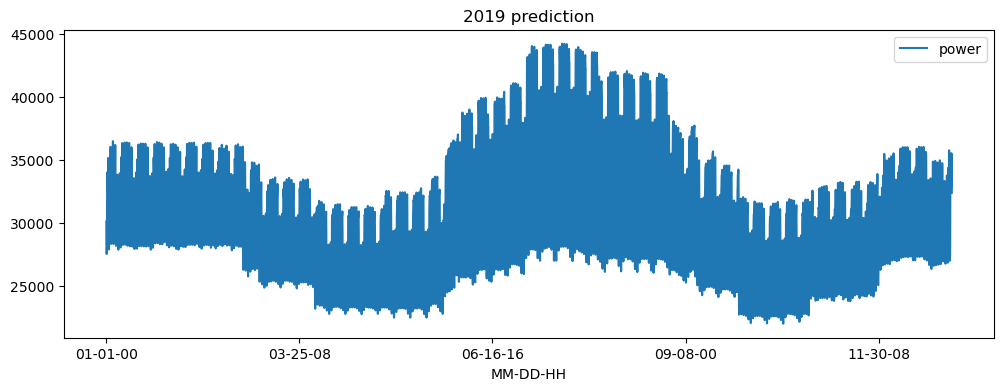

In [37]:
new_vis = pd.concat([y_df, processed_df], axis=1, join='outer')
new_vis['MM-DD-HH'] = pd.to_datetime(new_df['Datetime']).dt.strftime('%m-%d-%H')

new_vis = new_vis[new_vis['year']==2019]  # drop the rest date from 2018
new_vis.plot(x='MM-DD-HH', y='power', kind='line', figsize=(12, 4), title='2019 prediction')